In [1]:
from collections import Counter, defaultdict
from itertools import chain

import os.path
import sys

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import transforms
import pandas as pd

import imageio
from skimage.color import rgb2lab, lab2rgb
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import fcluster
from scipy.spatial.distance import squareform
from scipy.stats import gaussian_kde
from scipy.spatial import distance_matrix
from scipy.optimize import linprog

In [2]:
sys.path.append('/home/bhornung/Documents/flags/scripts/image-scripts')

from image_kmedoids import KMedoids

In [3]:
def decode_colour_code(code):
    """RGB to hex converter"""
    blue = code % 256
    red = code // (256 * 256)
    green = (code - red * 256 * 256) // 256
    
    return np.array([red, green, blue])


def create_image_histo(image):
    """hex to rgb converter"""
    encoder = np.array([256 * 256, 256, 1])
    codes, counts = np.unique((image * encoder).sum(axis=-1).flat, return_counts=True)
    fractions = [x / counts.sum() for x in counts]
    
    return codes, fractions


def process_clustering_results(
    clusterer,
    coords=None,
    weights=None,
    add_bw=False
):
    """Creates a dictionary of cluster centres"""

    # extract labels
    labels = clusterer.labels_

    # extract cluster centres
    if hasattr(clusterer, "cluster_centres_"):
        cluster_centres = dict(enumerate(clusterer.cluster_centres_))
    
    else:
    
        masks = {i: labels == i for i in np.unique(labels)}

        cluster_centres = {
            k: np.average(coords[v], weights=weights[v], axis=0)
            for k, v in masks.items()
        }   
        
    # convert to RGB
    cluster_centres = {
        k: lab2rgb(v.reshape(1, 1, 3)).reshape(3) 
        for k, v in cluster_centres.items()
    }

    # add white and black
    if add_bw:
        labels = np.hstack([labels.max() + 1, labels.max() + 2, labels])
        
        cluster_centres.update({
            max(cluster_centres.keys()) + 1: np.full((3), 1.),
            max(cluster_centres.keys()) + 2: np.full((3), 0.)
        })
    
    return labels, cluster_centres


def create_cc_mask(labels, label_by_colours):
    """Creates a masks for groups of clusters"""
    masks = {
        k : [labels == i for i in v]
        for k, v in label_by_colours.items()
    }

    masks = {
        k : np.any(np.stack(np.array(v), axis=1), axis=1)
        for k, v in masks.items()
    }
    
    return masks


def reclusterer(
    coords,
    weights,
    labels, 
    label_by_colours,
    n_cluster_by_colours
):
    """Groups clusters and reclusters them"""
    
    # masks the select certain clusters
    masks = create_cc_mask(labels, label_by_colours)
    
    # fit for all colours
    results = {}
    for k, m in masks.items():
        clusterer = KMedoids(n_clusters=n_cluster_by_colours[k])
        clusterer.fit(coords[m], weights=weights[m])

        lbs, ctrs = process_clustering_results(clusterer)
        labels_ = np.full_like(labels, -2)
        labels_[m] = lbs
        
        results.update({k :{
            "centres": ctrs,
            "labels": labels_}
        })
        
    return results


def merge_recluster_results(
    reclustered,
    centres,
    labels,
    label_by_colours
):
    """Creates consistent labels for a reclustering"""
    
    # store for new centre with removed
    # entries which have been split
    centres_new = dict(centres.items())
    for _, v in label_by_colours.items():
        for i in v:
            centres_new.pop(i)
    
    labels_new = labels.copy()
    idcs = np.arange(len(labels_new))

    # mask that covers one group
    # can be multiple original labels
    masks = create_cc_mask(labels, label_by_colours)
    
    ic = labels.max()
    # loop through groups
    for k, v in reclustered.items():
        
        mask_group = masks[k]
        
        # loop over **new** labels in  a group
        for il, c in v["centres"].items():
        
            # increase bookkeep counter
            ic += 1
            # select a new cluster
            mask_label = v["labels"][mask_group] == il
            k = idcs[mask_group][mask_label]# = ic
            labels_new[k] = ic
            
            # add centre
            centres_new.update({ic: c})

    return labels_new, centres_new


def calc_flag_distance(canvas1, canvas2, weights):
    
    diff = canvas1 - canvas2
    distance = np.average(
        np.sqrt((diff * diff).sum(axis=1)), weights=weights
    )
    
    return distance


def plot_vanity(x, w, labels, colour_centres=None, n_col=3):
    
    idcs = np.unique(labels)
    order = np.array([w[labels==i].sum() for i in idcs])
    idcs = idcs[np.argsort(order)[::-1]]
    
    n_clusters = len(idcs)
    n_row = n_clusters // n_col + (n_clusters % n_col != 0)
    
    fig, axes = plt.subplots(
        n_row,
        n_col,
        gridspec_kw={"hspace": 0.1, "wspace": 0},
        facecolor="#E9E9E9"
    )
    fig.set_size_inches(13, 13)
    ax_gen = (ax for ax in axes.flat)
    
    for i in idcs:
        
        mask = labels == i

        colours_outer = x[mask] / 255
        weights = w[mask]
        
        if colour_centres is None:
            colour_centre = np.average(x[mask], weights=w[mask], axis=0) / 255
        else:
            colour_centre = colour_centres[i]
            
        plot_nested_piechart(
            next(ax_gen),
            colours_outer,
            weights,
            colour_centre
        )
        
    _ = [ax.axis("off") for ax in ax_gen]
    
    
def plot_nested_piechart(ax, colours_outer, weights, colour_centre):
    size = 0.5

    weight_total = weights.sum()
    weights_ = weights / weight_total
    
    ax.set_title(f"Total weight: {weight_total:4.4f}")
    ax.pie(
        weights_,
        radius=1, 
        colors=colours_outer,
        wedgeprops=dict(width=size, edgecolor='w')
    )
    
    ax.pie(
        [1], 
        radius=1-size, 
        colors=[colour_centre]
    )
    
    ax.set(aspect="equal")
    

def plot_colour_histo(colours, counts, ax, n_plot, xlabel, ylabel):
    
    x = np.arange(1, 1 + n_plot)
    colours_ = [decode_colour_code(x) / 255 for x in colours[:n_plot]]
    ax.bar(x, counts[:n_plot], color=colours_)
    ax.set_facecolor("#E6E6E6")
    ax.set_xticklabels([]); ax.set_xlim(left=0); ax.grid(True, which="both")
    ax.set_xlabel(xlabel); ax.set_ylabel(ylabel); ax.set_ylim((0, 1))
    ax.set_yticks(np.linspace(0, 1, num = 11))
    

def plot_colour_stacked_bars(counter, colour_mapping, ax):
    
    colours, y = zip(*counter)
    nc = len(colours[0])
    colours = [[colour_mapping[cl] for cl in cls] for cls in colours]
    colours = np.array(colours)
    y = np.array([y] * nc) / nc
    y = np.vstack([np.zeros(y.shape[1]), y])
    y = np.cumsum(y, axis=0)
    x = np.arange(len(y.T))

    for i, (yl, yu) in enumerate(zip(y[:-1], y[1:])):
        ax.bar(x, yu - yl, bottom=yl, color=colours[:, i, :])
        
        
def plot_decomposed_horse(distances, clabels, colours, ax):
    """
    Creates a KDE decomposition of a distance matrix
    based on cluster labels.
    """

    gen_cl = (x for x in colours)
    
    # separate distances
    cli = np.unique(clabels)
    for i in cli:
        mask1 = clabels == i
        for j in cli[i-1:]:
            # select
            mask2 = clabels == j
            
            # calculate
            y = np.ravel(mat_lab[mask1][:, mask2])
            kde = gaussian_kde(y)
            x = np.linspace(y.min(), y.max(), num=100)
            y = kde(x)

            # plot
            ls = ["-", "-."][int(i) != int(j)]
            lw = [3, 1][int(i) != int(j)]
            ax.plot(
                x, np.ravel(y),
                color=next(gen_cl), label=(i, j),
                ls=ls, lw=lw
            )
            
    ax.legend(); ax.grid(True);
    ax.set_xlim(left=0); ax.set_ylim(bottom=0)
    
    
def xy_to_polar(x, y, xmin, xmax, origin, gap=0.01):
    """
    Transforms Cartesian to Cartesian but as if it were in polar.
    """
    
    phi = (x - xmin) / xmax * (2 * np.pi) * (1 - gap)
    r = origin - y
    
    x_ = np.cos(phi) * r
    y_ = np.sin(phi) * r
        
    return x_, y_


def smoothsegment(seg, n_smooth=100):
    """
    Interpolates between linkage segments.
    """
    
    sub_segments = [
        [seg[0]], np.linspace(seg[1], seg[2], n_smooth), [seg[3]]
    ]
    return np.concatenate(sub_segments)


def plot_polar_dendrogram(dendro, ax, offset=100):
    """
    Creates a polar dendrogram.
    """
    
    icoord = np.array(dendro["icoord"])
    dcoord = np.array(dendro["dcoord"])
    color_list = dendro["color_list"]

    origin = dcoord.max() + offset
    xmin = icoord.min()
    xmax = icoord.max()

    for xs, ys, c in zip(icoord, dcoord, color_list):

        xs = smoothsegment(xs)
        ys = smoothsegment(ys)
        xs, ys = xy_to_polar(xs, ys, xmin, xmax, origin)
            
        ax.plot(xs,ys, color=c)

    ax.set_xticks([]); ax.set_yticks([])
    
    
def plot_images_on_perimeter(images_small, image_order, radius, ax):
    """
    Orders and adds a sequence of images
    on the perimeter of a circle.
    """
    
    n_images = len(images_small)
    size = radius * 2 * np.pi / (n_images * 1.2)
    
    for i, im in enumerate(images_small[image_order]):
        
        phi = (i / n_images) * 2 * np.pi * (1 - 0.01)
        
        x = np.cos(phi) * radius
        y = np.sin(phi) * radius
    
        h, w = im.shape[:2]
        scafact = size / h
        
        tr = transforms.Affine2D()\
        .rotate_deg(phi*360/2/np.pi)\
        .scale(scafact, scafact)\
        .translate(x,y)
        ax.imshow(im, transform=tr + ax.transData)
        

def create_linprog(dmat, w_source, w_target):
    """
    Rearranges the distance/cost matrix of a
    transportation problem to scipy linprog form.
    """
    
    # in dmat each row is a distance between
    # a specific source node and all the target nodes 
    
    # coeff array
    # each block is a source --> targets list
    c = np.ravel(dmat)
    
    # equality constraints
    b_eq = np.hstack([w_source, w_target])
    
    # equality constraint matrix
    n_source, n_target = dmat.shape
    a_eq = np.zeros((n_source + n_target, n_source * n_target))
    
    # 
    for i in range(n_source):
        a_eq[i, n_target * i : n_target * (i + 1)] = 1
    
    for i in range(n_target):
        for j in range(n_source):
            a_eq[i+n_source, i + j * n_target] = 1
            
    # a_eq[-1] = 1

    return a_eq, b_eq, c


def calc_emd(dmat, w_1, w_2):
    """Calculates the earth mover's distance"""
    
    a_eq, b_eq, c = create_linprog(dmat, w_1, w_2)
    res = linprog(c, A_eq=a_eq, b_eq=b_eq, bounds=(0, 1))
    
    d_dot_f = res["fun"]
    f_vector = res["x"]
    
    d_emd = d_dot_f / f_vector.sum()
    
    return d_emd

def add_text_on_perimeter(texts, radius, ax):
    
    n = len(texts)

    for i, text in enumerate(texts):
                      
        phi = i / n * 2 * np. pi * (1 - 0.01)
        x = np.cos(phi) * radius
        y = np.sin(phi) * radius
        
        ax.text(x, y, text.upper(), rotation=(-phi * 180 / np.pi), rotation_mode="anchor", ha="left", va="top")
        
    ax.axis("off")
    ax.set_facecolor("#f9f9f9")
    fig.set_facecolor("#f9f9f9")
    
def add_radial_lines(ax, radius):
    for phi in np.linspace(0, 2*np.pi, 12, endpoint=False):
        x = np.cos(phi) * np.linspace(0, radius)
        y = np.sin(phi) * np.linspace(0, radius)
        
        ax.plot(x, y, lw=1, ls="--", c="grey", zorder=0)

## Motivation

This blog post seeks to entertain the reader with a statistical analysis of the flags of countries from around the world. Similarities and differences are uncovered and quantified.

## Miscellaneous

The notebook presented here only contains those segments of the code employed which have been deemed insightful of necessary to understand the logic of the analysis. The raw notebook with the army of scripts employed can be found [here](https://github.com/bhornung/bhornung.github.io/blob/master/assets/flags-3/notebook/flags-3.ipynb).

## Data

The images of the flags have been obtained from the respective wikipedia pages. They were originally in `svg` format from which they were converted to `png`. They are loaded from the disk and stored in a dictionary keyed by the country names: 

In [4]:
path_to_image_folder = "/home/bhornung/Documents/flags/data/clean-data/images/png/"
files = os.listdir(path_to_image_folder)
path_to_images = [os.path.join(path_to_image_folder, x) for x in files]

In [5]:
images = (
    (x.split("/")[-1].split(".")[0], imageio.imread(x)) 
    for x in path_to_images
)

In [6]:
flags = {k: {"canvas": v} for k, v in images}

## Preliminaries

### Notation
Let the set of all colours denoted by $\mathcal{C}$:
$$
\emptyset \neq \mathcal{C} \subset \mathbb{R}^{3} \, .
$$

A flag, $F$ is an ordered tuple of colours, or, if you will, a two-dimensional sequence of pixels:

$$
F \in \mathcal{C}^{N\times M} \, .
$$

The flags are indexed by $i$. The $i$-th flag has a height of $n_{h,i}$ and width of $n_{w,i}$:

$$
F_{i} \in \mathcal{C}^{n_{h,i} \times n_{w,i}} \, .
$$

$c_{ij}$ is the $j$-th colour in the $i$-th flag. The number of colours in $F_{i}$ is denoted by $n_{i}$ The entirety of colours in a flag constitute a set:
$$
\mathcal{C}_{i} = \bigcup  \limits_{j=1}^{n_{i}} c_{i, j} \, .
$$

## Analysis

The colourful aspects of flags are quantified in the following sections.

### Colour encoding
For the ease of manipulation, every colour is encoded by a string. 

### Flags
There are $N_{f}=196$ flags in total. They differ in size and shape. However, all of them will be treated as though they had unit area.

### Colour histograms
A selection of image properties are generated, such as the area based histogram of the colours, $\mathbf{w}_{i}$. The histograms contain the areas of distinct colours divided by the area of the entire flag:

$$
\begin{eqnarray}
    \mathbf{w}_{i} &=& \in \mathbb{R}^{n_{i}} \\
    w_{ij} &=& \sum\limits_{k=1}^{n_{h,i}}\sum\limits_{l=1}^{n_{w,i}}
    \frac{\delta_{c_{ij}, p_{kl}}}{n_{h,i}, n_{w,i}} \, ,\quad
    j \in \left[1, ..., n_{i} \right]
\end{eqnarray}
$$

These probability fingerprints are then loaded in a dataframe.

In [7]:
histo = {k: dict(zip(("colours", "fractions"), create_image_histo(v["canvas"])))
         for k, v in flags.items()}

In [8]:
df_flag = pd.DataFrame.from_dict(histo, orient="index")

### Colour spaces and distances

The colours are given in RGB colour model. The RGB colour distances are rather different to how humans perceive dissimilarities between colours. The _L\*a\*b*_ coordinates are thus calculated between which the $L_{2}$ distances better approximate the human perception.

In [9]:
df_flag["colours-rgb"] = df_flag["colours"].apply(
    lambda x: np.array([decode_colour_code(y) for y in x])
)

df_flag["colours-lab"] = df_flag["colours-rgb"].apply(
    lambda x: rgb2lab(x.reshape(-1, 1, 3) / 255).reshape(-1, 3))

### Number of colours

A simple descriptor of complexity is the number of colours in a flag, $n_{i}$. Most of the flags are composed of a handful of colours, less than or equal to ten. There are a few outliers with ten or more, even hundreds of tints. They will dicussed in due course. About eighty percent of the flags have at most four colours. The combination of three components is the most frequent. The average number of colours in a flag is $3.87\approx 4$.

In [10]:
# TO SKIP -- NIHIL NOVI SUB SOLE
df_flag["n-colour"] = df_flag["colours"].apply(len)

Text(0.5, 1.0, 'Histogram of colour numbers (zoom)')

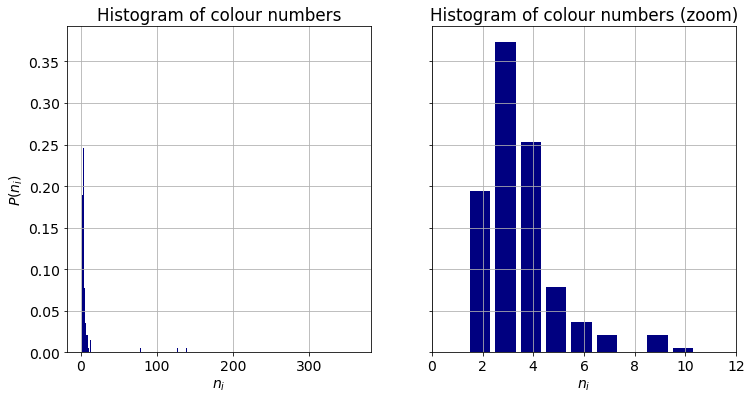

In [11]:
plt.rcParams.update({"font.size": 14})
# TO SKIP -- PLOT SETUP
fig, axes = plt.subplots(1, 2, sharey=True)
fig.set_size_inches(12, 6)
ax = axes[0]

_ = ax.hist(
    df_flag["n-colour"],
    bins=np.arange(df_flag["n-colour"].max()),
    density=True, align="left",
    color="navy"
)

ax.set_title("Histogram of colour numbers")

ax.grid(True); ax.set_xlabel(r"$n_{i}$"); ax.set_ylabel(r"$P(n_{i})$")

ax = axes[1]
_ = ax.hist(
    df_flag.loc[df_flag["n-colour"] < 20, "n-colour"], 
    bins=np.arange(df_flag["n-colour"].max()),
    density=True, align="left",
    width=0.8, color="navy"
)
ax.grid(True); ax.set_xlim((0, 12)); ax.set_xlabel(r"$n_{i}$")
ax.set_title("Histogram of colour numbers (zoom)")

A closer look at the outliers reveals that the high number of colours are due to areas in which hues are continuously changing, such as in the case of Belize. Alternatively, an intricate crest position on the canvas can increase the number of colours substantially as the one does in the flag of Spain. It is worth noting, that seven of the countries are located in Central America. We will touch upon this observation when dicussing the similarities between flags.

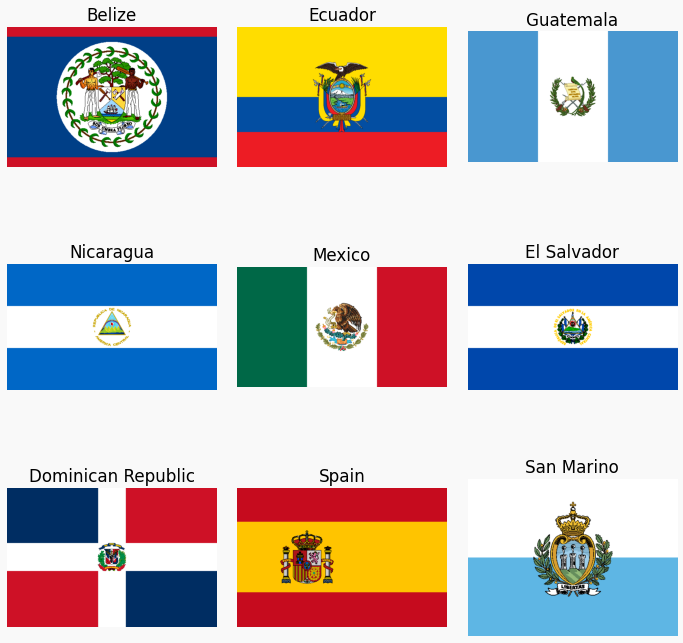

In [12]:
# TO SKIP -- PLOT SETUP

sel = [
    'belize', 'ecuador', 'guatemala', 
    'nicaragua', 'mexico', 'el salvador',
     'dominican republic', 'spain', 'san marino'
]

fig, axes = plt.subplots(3, 3, gridspec_kw={"wspace": 0.1})
fig.set_size_inches(12, 12)

for ax, x in zip(axes.flat, sel):
    ax.imshow(flags[x]["canvas"])
    ax.axis('off')
    ax.set_title(x.title())
fig.set_facecolor("#f9f9f9")    
plt.show()

#### Treatment of outliers

In order to make the following analysis and illustrations more coherent, the histograms of the nine flags are truncated and renormalised at the first ten largest contributing colours. The discarded ones have negligible weights.

In [13]:
df_flag.loc[sel, "colours"] = df_flag.loc[sel, "colours"].apply(lambda x: x[:10])
df_flag.loc[sel, "colours-rgb"] = df_flag.loc[sel, "colours-rgb"].apply(lambda x: x[:10])
df_flag.loc[sel, "colours-lab"] = df_flag.loc[sel, "colours-lab"].apply(lambda x: x[:10])
df_flag.loc[sel, "fractions"] = df_flag.loc[sel, "fractions"].apply(lambda x: np.array(x[:10]))
df_flag.loc[sel, "fractions"] = df_flag.loc[sel, "fractions"].apply(lambda x: x / x.sum())
df_flag.loc[sel, "n-colour"] = 10

### Colour distribution in individual flags

The number of colours is a limited descriptor. It does not carry any information about the ratio of the constituent colours of a flag. It might as well be that one flag is divided equally between three colours. An other one only have one--one percent contributions of the second and third colours. These cases remain indistinghuished by the above metric. The distribution of colours in a flag can be quantified by several indices. We choose the _efficiency_ or normalised entropy. 

$$
\eta_{i} = - \frac{\sum\limits_{j}^{n_{i}} w_{ij} \log(w_{ij}) }{\log(n_{i})}
$$

Efficiency has a clear meaning: unit refers to equally distributed colours. The limit of zero means that a single colour covers almost the entire canvas. It also owns the favourable property of having the same lower an upper limits independent of the number of colours. As such, it provides a straightforward way to compare distributions across all of the flags. 

In [14]:
def calc_efficiency(x):
    """Calculates the normalised entropy aka efficiency."""
    h = - np.dot(np.log(x), x) / np.log(len(x))
    return h

In [15]:
df_flag["efficiency"] = df_flag["fractions"].apply(calc_efficiency)

The probability density and cumulative distribution functions of the efficiency are shown below. The mode of the distribution is at unit, so that the most frequent type of flag equally distributes its area among its colours. There is an interesting second maxima around 0.8 and a stanalone cluster at 0.2. These are coming from flags of roughly uniformly and disproportionately divided areas.

Text(0.5, 1.0, 'Efficiency distribution of colours')

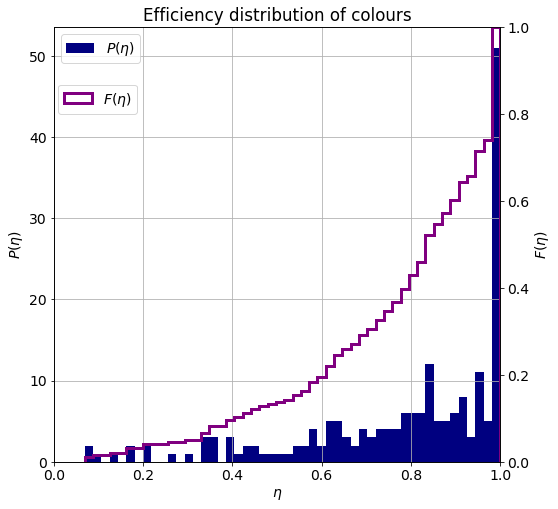

In [16]:
# TO SKIP -- PLOT SETUP
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(8, 8)
_ = ax.hist(
    df_flag["efficiency"].values,
    bins=50, density=False,
    color="navy",
    label=r"$P(\eta)$"
)
ax.set_xlim((0, 1)); ax.grid(True); ax.set_xlabel(r"$\eta$"); ax.set_ylabel(r"$P(\eta)$")
ax.legend()

ax1 = ax.twinx()

_ = ax1.hist(
    df_flag["efficiency"].values,
    bins=50, density=True, cumulative=True,
    color="purple", lw=3, histtype="step",
    label=r"$F(\eta)$"
)

ax1.set_ylim((0, 1)); ax1.set_ylabel(r"$F(\eta)$"); ax1.legend(loc=(0.01, 0.8))
ax.set_title("Efficiency distribution of colours")

### Joint number and diversity distributions

We already know which are the most frequent numbers and distribution patterns of colours. It is rather intriguiging to investigate how these two quantifiers are related to each other. A joint histogram $P(n, \eta)$ can reveal clusters of flags, whereas the conditional distribution function $P(\eta | n)$ uncovers regularities as a function of the number of colours.

In [17]:
hist_n_eta_joint = np.histogram2d(
    df_flag["n-colour"],
    df_flag["efficiency"],
    bins=(9, 30),
    range=[[2, 11], [0, 1]]
)[0].T

hist_n_marg = hist_n_eta_joint.sum(axis=0)
mask = hist_n_marg != 0
hist_n_eta_cond = np.zeros_like(hist_n_eta_joint)
hist_n_eta_cond[:, mask] = hist_n_eta_joint[:, mask] / hist_n_marg[mask][None, :]

Text(0.5, 1.0, '$P(\\eta | n)$')

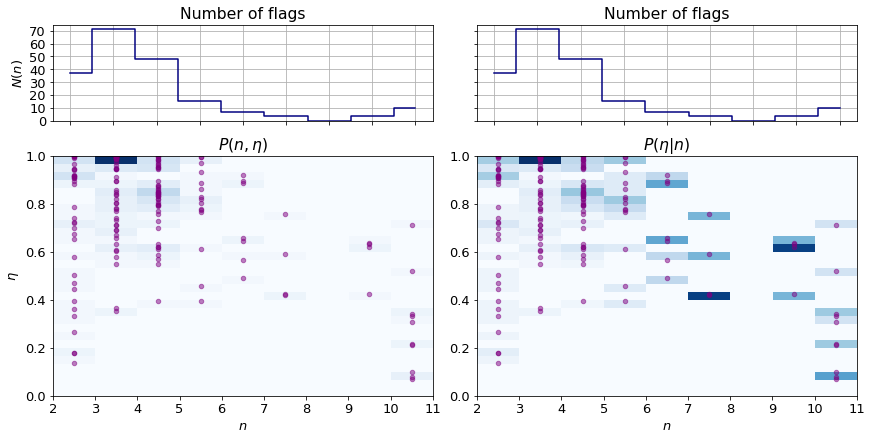

In [18]:
plt.rcParams.update({"font.size": 13})
fig = plt.figure(constrained_layout=True)
fig.set_size_inches(12, 6)

gs = fig.add_gridspec(7, 8)
ax1 = fig.add_subplot(gs[0:2, :4])
ax2 = fig.add_subplot(gs[0:2, 4:])
ax3 = fig.add_subplot(gs[2:, :4])
ax4 = fig.add_subplot(gs[2:, 4:])

ax1.step(np.arange(9), hist_n_marg, color="navy", where="mid")
ax2.step(np.arange(9), hist_n_marg, color="navy", where="mid")
ax1.set_ylabel(r"$N(n)$"); 
ax1.set_yticks(range(0, 80, 10)); ax2.set_yticks(range(0, 80, 10));
ax1.set_xticklabels([]); ax2.set_xticklabels([]); ax2.set_yticklabels([])
ax1.grid(True); ax2.grid(True); ax1.set_ylim(bottom=0); ax2.set_ylim(bottom=0)

ax3.imshow(hist_n_eta_joint, aspect="auto", cmap="Blues", extent=(2, 11, 0, 1), origin="bottom")
ax4.imshow(hist_n_eta_cond, aspect="auto", cmap="Blues", extent=(2, 11, 0, 1), origin="bottom")
ax3.set_xlabel(r"$n$"); ax4.set_xlabel(r"$n$"); ax3.set_ylabel(r"$\eta$");


ax3.scatter(
    df_flag["n-colour"] + 0.5,
    df_flag["efficiency"],
    color="purple", s=20, alpha = 0.5
)

ax4.scatter(
    df_flag["n-colour"] + 0.5,
    df_flag["efficiency"],
    color="purple", s=20, alpha = 0.5
)

ax1.set_title("Number of flags"); ax2.set_title("Number of flags")
ax3.set_title(r"$P(n, \eta)$"); ax4.set_title(r"$P(\eta | n)$")

The bottom left panel of the figure above $P(n, \eta)$ whilst the one next to it depicts $P(\eta | n)$. The individual data are overlaid as purple cirles. For the ease of discussion, the count of flags composed of a certain number of colours are plotted above the joint plots.

The following observations can be made:
* The most frequent flag type is of displaying three colours in equal or almost equal ratio.
* There is a pronounced cluster of $n=\{4, 5\}$ flags of uneven colour shares.
* Flags with higher number of colours tend to distribute them inequally.
* The rare occurence of flags with number of colours greate than seven makes it difficult to make statistically relevant statements.

## Colours

We now proceed to investigate the colours themselves. 

### Colour propensity

For all colours, the number of flags in which they appear is counted and a histogram is formed:

$$
   r_{j} = \frac{\sum\limits_{i=1}^{N_{f}} \mathbf{1}_{\mathcal{C}_{i}}(c_{j})}{N_{f}} \, .
$$

where $\mathbf{1}_{\mathcal{S}}$ is the indicator function. These ratios do not take into account the areas occupied by them. The counts are thus weighted by the colour weight to obtain a more descriptive measure:

$$
   r_{w,j} = \frac{\sum\limits_{i=1}^{N_{f}} \mathbf{1}_{\mathcal{C}_{i}}(c_{j}) \cdot w_{i,j}}{N_{f}} \, .
$$

Please note, the colour weights sum up to the number of flags: 

$$
\sum\limits_{i=1}^{N_{f}}\sum\limits_{j=1}^{N_{c, j}} = N_{f} \, .
$$

In [19]:
# non-weighted
colours, counts = np.unique(
    np.array(list(chain(*df_flag["colours"].values))),
    return_counts=True
)
idcs = np.argsort(counts)[::-1]
colours, counts = colours[idcs], counts[idcs]
counts = counts / len(df_flag)

# weighted
df_ = pd.DataFrame.from_records({
    "cls": list(chain(*df_flag["colours"].values)),
    "whs": list(chain(*df_flag["fractions"].values))
})

df_ = df_.groupby(["cls"])["whs"].sum().sort_values(ascending=False)
colours_w, counts_w = df_.index.values, df_.values
counts_w = counts_w / counts_w.sum()

White appears on about seventy percent of the flags. One third of them contain black, and one fifth contain pure red. Yellow is relatively popular with its propensity of fifteen percent. None of the other specific colours can be seen in more than five percent of the flags.

In terms of total area occipied (right panel), white comes first with a share of about eighteen percent. It means that this colour covers the quarter ($18/70 \approx 0.25$) of the flag whenever it is featured. It is worthwhile noting that the while colour black is in approximately twice as many as many flags than red, their area ratios are roughly equal. The reason lies in black is being used only to accentuate smaller details in many cases. The rest of the indvidual colours have marginal coverage.

Text(0.5, 1.0, 'Colour histogram (weighted)')

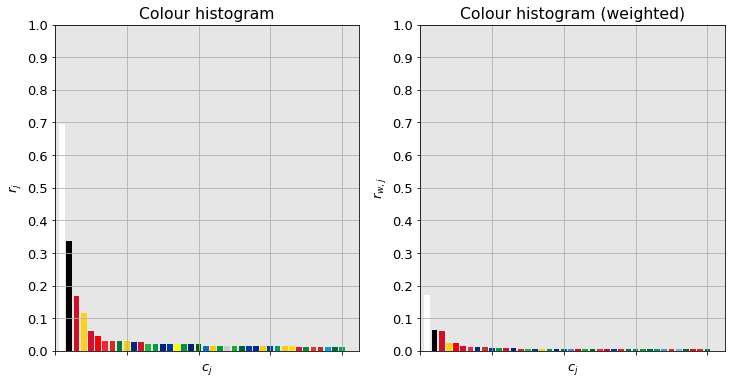

In [20]:
# TO SKIP -- PLOT SETUP
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(12, 6)
plot_colour_histo(colours, counts, axes[0], 40, "$c_{j}$", r"$r_{j}$")
plot_colour_histo(colours_w, counts_w, axes[1], 40, "$c_{j}$", r"$r_{w,j}$")
axes[0].set_title("Colour histogram"); axes[1].set_title("Colour histogram (weighted)")

## Colour clustering

One readily notice the similarity between the colours in the plots above. They are however treated as separate ones. It is possible distinguish certain groups of colour _e.g_ dark red, light green, dark green which are akin to the extent that they could be considered identical. This observation brings about the idea of clustering the colours.

### Choosing colour space
The colours are converted to the _L\*a\*b\*_ colour space in which the distances better approximate human colour perception.

In [21]:
coords = np.array([decode_colour_code(x) for x in colours_w])
coords_lab = rgb2lab(coords.reshape(-1, 1, 3)/255).reshape(-1, 3)

The plots below show the propensity of colours in thehe _L\*a\*b\*_ frame and their projections onto the planes spanned by the pairs of axes.

(-105.0, 105.0)

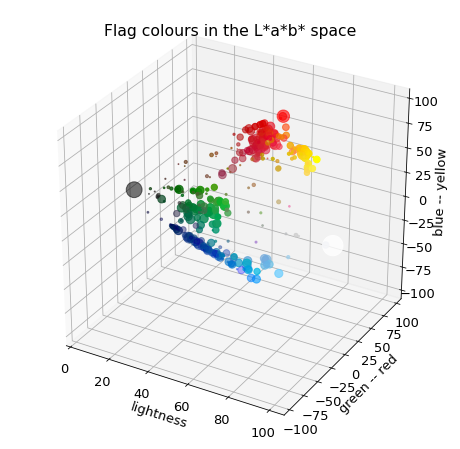

In [22]:
# TO SKIP -- PLOT SETUP
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
fig.set_size_inches(8, 8)
ax = fig.add_subplot(111, projection = '3d')

ax. scatter(
    coords_lab[:, 0], coords_lab[:, 1], coords_lab[:, 2], 
    c=coords / 255, s=np.sqrt(counts_w) * 1000
)

ax.set_title("Flag colours in the L*a*b* space")
ax.set_xlabel("lightness"); ax.set_ylabel("green -- red"); ax.set_zlabel("blue -- yellow")
ax.set_xlim((0, 105)); ax.set_ylim((-105, 105)); ax.set_zlim((-105, 105))

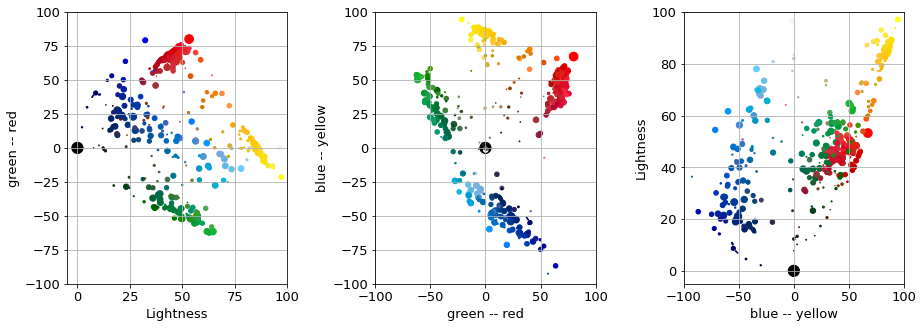

In [23]:
# TO SKIP -- PLOT SETUP
fig, axes = plt.subplots(1, 3, gridspec_kw={"wspace": 0.4})
fig.set_size_inches(15, 5)

axes[0].scatter(coords_lab[:, 0],coords_lab[:, 1], c=coords / 255.0, s=np.sqrt(counts_w) * 500)
axes[1].scatter(coords_lab[:, 1],coords_lab[:, 2], c=coords / 255.0, s=np.sqrt(counts_w) * 500)
axes[2].scatter(coords_lab[:, 2],coords_lab[:, 0], c=coords / 255.0, s=np.sqrt(counts_w) * 500)

axes[0].set_xlim((-5, 100)); axes[1].set_xlim((-100, 100)); axes[2].set_xlim((-100, 100));
axes[0].set_ylim((-100, 100)); axes[1].set_ylim((-100, 100)); axes[2].set_ylim((-5, 100));
#
axes[0].set_xlabel("Lightness"); axes[1].set_xlabel("green -- red"); axes[2].set_xlabel("blue -- yellow");
axes[0].set_ylabel("green -- red"); axes[1].set_ylabel("blue -- yellow"); axes[2].set_ylabel("Lightness");
_ = [ax.grid(True, which="both") for ax in axes]

### Colour groups

A handful of blobs can be identified by a cursorily look: red, pale and dark green, pale, medium and dark blue, yellow and orange. There is also a scattering of colours between the main groups which does not form a cluster. Some colours continuously blend into each other such as the pale green $\rightarrow$ dark green transition. This might imply the use of space partitioning methods such as _k_-means or _k_-medoids. The blobs are not of spherical shape which plays _practically_ against the use of distribution based method.

#### Choosing a clustering method

We need a method that considers the local density of the colours and can cope with elongated continuous shapes. We also have to decide whether all points should belong to clusters. Along the following thoughts choose we the algorithm:

* Distribution based methods _e.g._ are likely to go belly up because of the low number of points, if they are fully paramtrised. If not, the blobs are not Gaussian looking so they might be of limited use.
* Meanshift is out of question because of the bandwidth parameter would vary across regions.
* _k_-means is just too crude, the space does not have a Voronoi-like structure.
* _k_-medoids also partitions the space which might come useful when separating the transitioning colours. It also has the favouranle property of selecting an existing colour as the cluster centre.
* Affinity propagation, just like the _k_-medoids chooses am existing colour as a centre. However, it tends to be too greedy.
* Agglomerative clustering implicitly considers local density _via_ gradually building up the clusters. However, uneven density can result in either too many or too large groups depending on the cutoff value.
* DBSCAN and OPTICS can consider varying densities.

#### Choice

We will invoke a two step clustering process. 
* The first step of which separates dense regions of colours. 
* The second one partitions, further refines the so found clusters.

It turns out, _k_-medoids with colour weights and DBSCAN yield aesthetically reasonable clusterings. The word "aesthetically" was used on purpose. We are seeking to group the colours that preceptually similar. The emphasis is less mathematical this time. Also, the _L*a*b*_ colour space is not exact either.

#### K-medois

The reader is spared from the usual hyperparameter optimisation. It was of limited joy of mine, it would be certain that to the audience. The best _k_-medoids results are presented below.

In [24]:
#  k-medoids
clusterer_kmed = KMedoids(n_clusters=7, seed=10)
clusterer_kmed.fit(coords_lab[2:], weights=counts_w[2:])
labels_kmed, centres_kmed = process_clustering_results(clusterer_kmed, add_bw=True)

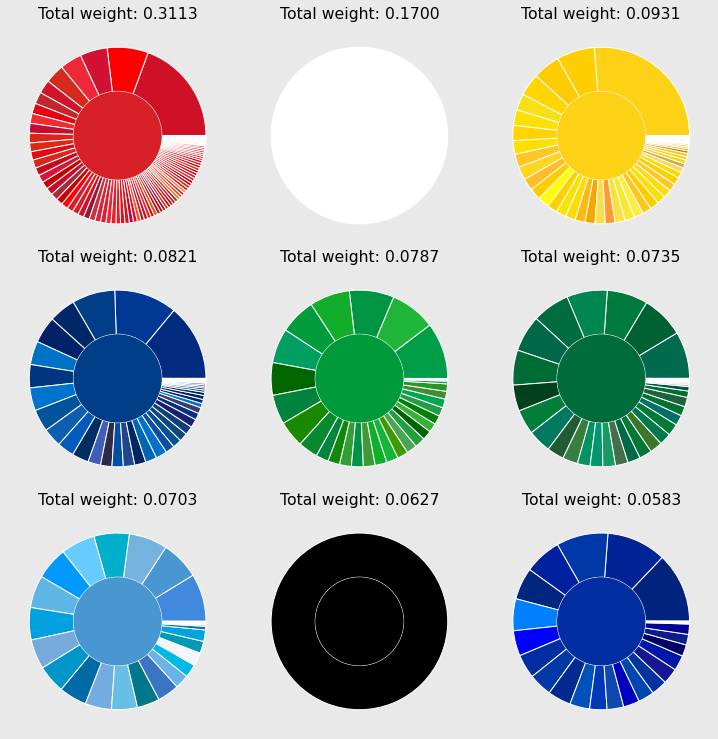

In [25]:
# TO SKIP -- PLOT SETUP
plot_vanity(coords, counts_w, labels_kmed, colour_centres=centres_kmed)

There are nine clusters in total
* red, white, black
* yellow
* two shades of green
* three shades of blue

The area which they cover across all flags are displayed as the _total weight_. The smallest cluster has a four percent share. Assuming that each flag is composed of the average four colours, this medium blue colour can be found in about twenty percent of the flags.

Some colour wheels contain unalike colours, such as the dark green slice at four o'clock in the middle wheel. There are two possible causes of this phenomenon. Either the distances in the used colour space do not reflect the human perception sufficiently. Alternatively, the paritioning algorithm is too crude. There many regions pushing each other back and forth during the iterative paritioning which can influence the global assignment of cluster labels. 

#### Refinement

To refine the assignment, the clusters of similar hue
* are grouped together
* and reclustered using a larger number of centres

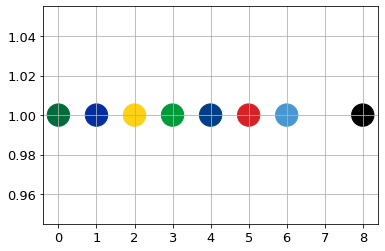

In [26]:
# TO skip -- DO NOT SHOW
fig, ax = plt.subplots(1, 1)
y = np.full(len(centres_kmed), 1)
x, c_ = zip(*centres_kmed.items())
c_ = np.array(c_)
ax.scatter(x, y, c=c_, s=500)
ax.set_xticks(range(0,9)); ax.grid(True)

In [27]:
# TO SKIP -- DETAIL
label_by_colours_kmed = {
    "yellow": [2, 5],
    "green": [0, 3],
    "blue": [1, 4, 6]
}

n_clus_bc_kmed = {
    # "red": 4,
    "yellow": 7,
    "green": 3,
    "blue": 4
}

In [28]:
# TO SKIP -- DETAIL
lfs = reclusterer(
    coords_lab,
    counts_w,
    labels_kmed,
    label_by_colours_kmed,
    n_clus_bc_kmed
)

In [29]:
# TO SKIP -- DETAIL
labels, centres = merge_recluster_results(
    lfs,
    centres_kmed,
    labels_kmed[0:],
    label_by_colours_kmed
)

 The sixteen clusters are shown below. The colours are now more homogenously grouped to gether. It is especially worth noting the appearance of four shades of red. The lowest fraction is just below one percent, thus all of the main colours have a singificant contribution.

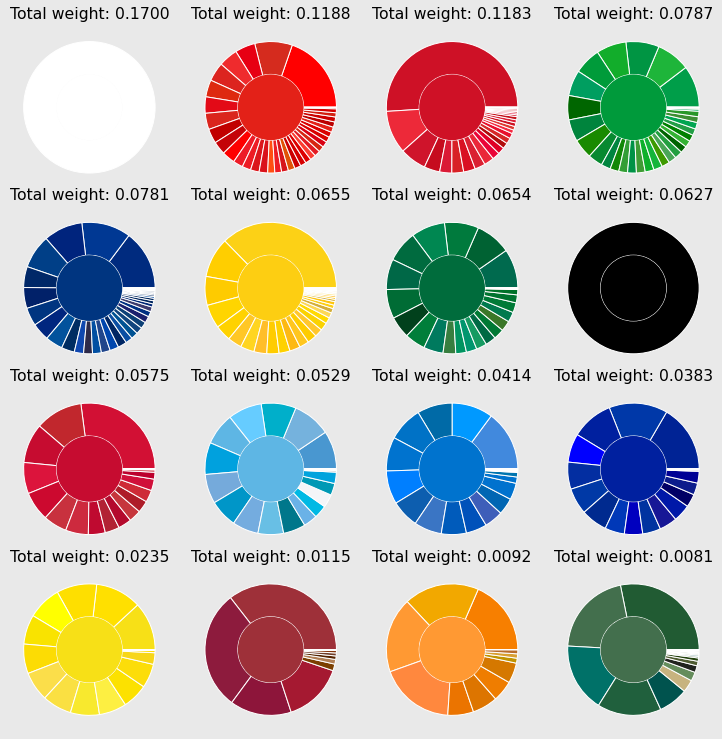

In [30]:
# TO SKIP -- PLOT SETUP
plot_vanity(
    coords[0:],
    counts_w[0:],
    labels,
    colour_centres=centres,
    n_col=4
)

#### Cluster analysis

It is interesting to measure how much the original and the centre colours whose cluster they belog to deviate across all flags. In other words, the differences between the orignal canvases and the ones in which the colours have been replaced by the centre of the cluster to which they belong. Firstly, all _L*\a\*b\*_ components in each flag mapped to their cluster centres.

In [31]:
# cluster centres in L*a*b*
centres_lab = {
    k: rgb2lab(v.reshape(1, 1, 3)).reshape(3) for k, v in centres.items()
}

# create colour index -- cluster label mapping
colour_label_mapper = dict(zip(colours_w, labels))

# assign cluster label to each colour in all flags
df_flag["colours-label"] = df_flag["colours"].apply(
    lambda x: [colour_label_mapper[y] for y in x]
)

# look up L*a*b* colours of the label
df_flag["colours-lab-main"] = df_flag["colours-label"].apply(
    lambda x: [centres_lab[y] for y in x]
)

If the cluster centre of the _j_-th colour in the _i_-the flag is $c^{*}_{ij}$, then the distance between the original and clustered pairs can be given as:

$$
d_{i}^{c} = \sum\limits_{j=1}^{n_{c,i}} ||c_{ij} - c^{*}_{ij}||_{2} \cdot w_{ij} \, .
$$

In [32]:
df_flag["orig-main-dist"] =\
df_flag[["colours-lab", "colours-lab-main", "fractions"]].apply(
    lambda x: calc_flag_distance(*x), axis=1
)

The histogram and cumulative distribution function of the distances are plotted below. An average human observer can distinguish between two colours if their distance is greater than unit. This threshold is exceeded by about ninety percent of the flags. Values above five indicate colours that are considered different by humans, in which category about the sixty percent of the flags fall.

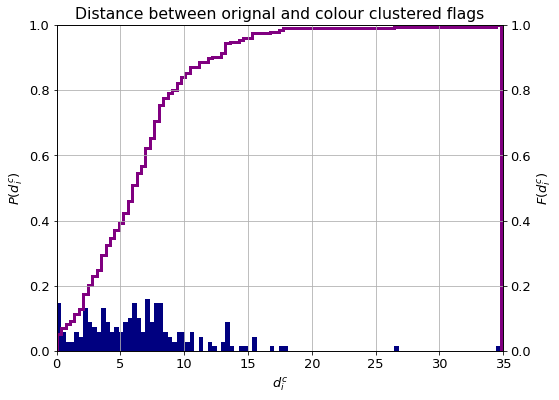

In [33]:
# TO SKIP -- PLOT SETUP
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(8, 6)
_ = ax.hist(df_flag["orig-main-dist"], bins=100, density=True, color="navy")

ax.set_xlabel(r"$d_{i}^{c} $"); ax.set_ylabel("$P(d_{i}^{c})$")
ax.set_xlim((0, 35)); ax.set_ylim((0, 1)); ax.grid(True, which="both");

ax1 = ax.twinx()
_ = ax.hist(
    df_flag["orig-main-dist"],
    bins=100, density=True, cumulative=True,
    histtype="step", color="purple", lw=3)
ax1.set_ylabel(r"$F(d_{i}^{c})$")

_ = ax.set_title("Distance between orignal and colour clustered flags")

### Co-occurence of colours

We now have a look at what colours tend to appear together. There are two ways of looking at this problem. One can either enumerate all flags composed of the same number of colours and count how many flags of the same group (_e.g_ bicolor, tricolor) contain the same colours. Alternatively, one can look for the same colour tuples appearing across all of the flags. These concepts are colourfully illustrated below.

In [34]:
edges = defaultdict(int)  #  any cooccurrence 
pairs = defaultdict(int)  #  pairs only in 2-colour flags
triplets = defaultdict(int)  #  only triplets only in 3-colour flags 
triplet_pairs = defaultdict(int)  #  pairs only in 3-colour flags 

for clbs in df_flag["colours-label"]:
    
    clbs_ = tuple(sorted(clbs))
    
    if len(clbs_) == 2:
        pairs[clbs_] += 1
    
    elif len(clbs_) == 3:
        triplets[clbs_] += 1
        triplet_pairs[clbs_[:2]] += 1
        triplet_pairs[clbs_[1:]] += 1
        triplet_pairs[(clbs_[0], clbs_[2])] += 1
    
    for i, l1 in enumerate(clbs_):
        for l2 in clbs_[i:]:
            edges[(l1, l2)] += 1

In [35]:
pairs = sorted(pairs.items(), key=lambda x: x[1])[::-1]
triplets = sorted(triplets.items(), key=lambda x: x[1])[::-1]
triplet_pairs = sorted(triplet_pairs.items(), key=lambda x: x[1])[::-1]

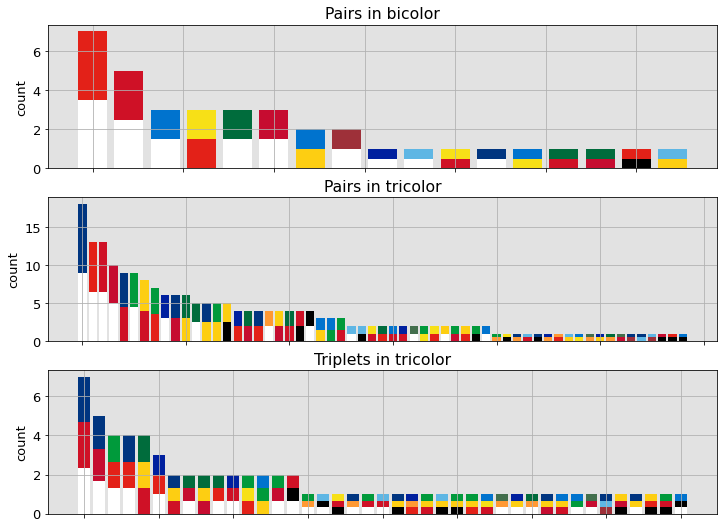

In [36]:
# TO SKIP -- PLOT SETUP
fig, axes = plt.subplots(3, 1)
fig.set_size_inches(12, 9)

dt = [pairs, triplet_pairs, triplets]
plb = [
    "Pairs in bicolor",
    "Pairs in tricolor",
    "Triplets in tricolor"
]

for ax, dt_, plb_ in zip(axes.flat, dt, plb):
    
    plot_colour_stacked_bars(dt_, centres, ax)
    ax.grid(True); ax.set_ylabel("count")
    ax.set_facecolor("#e2e2e2")
    ax.set_title(plb_)
    ax.set_xticklabels([])

The topmost panel is a statistics over bicolor flags. It shows that the red--white combination is by far the most popular. The middle panel characterises tricolor flags by counting the number of time a cerain pair of colours appear in them. The dominance of the red--white pair is unquestionable. Yellow--other colour couples also have a considerable share. The panel in the bottom is a histogram of tricolor flag compositions. Red--blue--white is being the most frequent.

### Create graph

It is also possible to count all pairs across all flags. By doing so, a graph is created where each node is a colour and each edge represents a cooccurance. The weight of the edge is proportional to the number of flags in which the two connected colours appear together.

/home/bhornung/anaconda3/lib/python3.7/site-packages/pygraphviz/agraph.py:1341: RuntimeWarning: Error: remove_overlap: Graphviz not built with triangulation library

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)
/home/bhornung/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


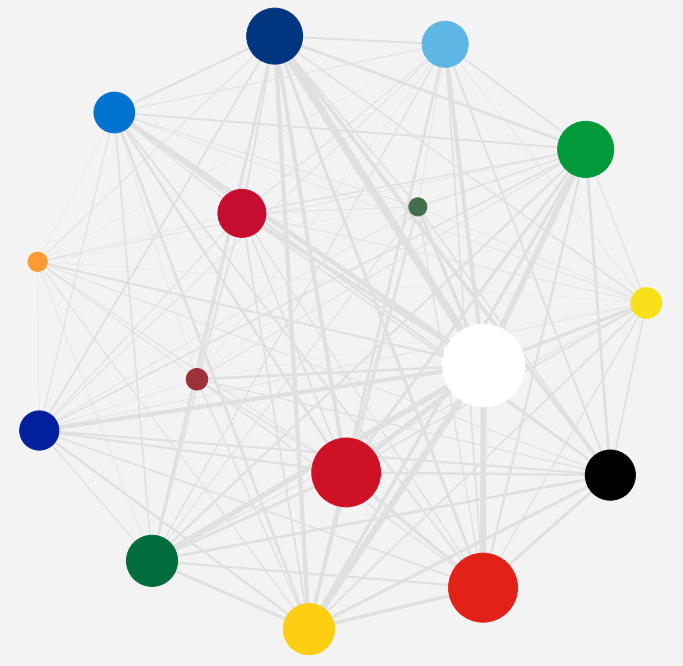

In [37]:
# TO SKIP -- BORING
from collections import defaultdict
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout as layout

# count edges
edges = defaultdict(int)
for ls in df_flag["colours-label"]:
    for i, l1 in enumerate(ls):
        for l2 in labels[i:]:
            edges[(l1, l2)] += 1

# create graph
g = nx.Graph()
for e, w in edges.items():
    g.add_edge(*e, weight=w)  # no, it won't affect the layout engine

# cosmetics
idcs = np.unique(labels)
order = np.array([(counts_w[labels == i]).sum() for i in idcs])
node_sizes = dict(zip(idcs, order))

node_size = [node_sizes[x]*40000 for x in g.nodes]
node_color = [centres[x] for x in g.nodes]
edge_width = [edges[x] / 800 for x in g.edges]

# create figure
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(12, 12)

pos = layout(g, prog="sfdp")

nx.draw(
    g, pos, 
    with_labels=False, 
    node_size=node_size, 
    width=0, 
    node_color=node_color
)

nx.draw_networkx_edges(g, pos, edge_color="#e0e0e0", width=edge_width)
fig.set_facecolor("#f3f3f3")
plt.show()

## Flag similarity

If anything, the observation from the digression transpires that some flags are  more similar to each other than others. The similarity is quantified in this section.

### Overlap in the _L\*a\*b\*_ space

A straightforward way to measure similarity, or distance, is to calculate pointwise the $L_{2}$ distance between the flags. Up until now all of the canvases had equal area. They, in reality, have differenct shapes and sizes which makes it impossible to compare any arbitrary pairs pixel-by-pixel. Rescaling the images to the same size and shape might be a solution, altough a costly one. It is rather easier to define a grid over the canvas in terms of relative height and width coordinates.

If the flag $F_{i}$ has the shape of $n_{h, i}, n_{w, i}$ and it is sampled at $N_{h}$ and $N_{w}$ equidistant vertical and horizontal raster points, the pixel coordinates of them are given by:
$$
\begin{eqnarray}
\delta_{h,i} &=& \frac{n_{h,i}}{n_h - 1} \\
\delta_{w,i} &=& \frac{n_{w,i}}{n_w - 1} \\
r_{h, i, k} &=& \left \lfloor \frac{k\cdot \delta_{h,i}}{n_{h,i}} \right \rceil \\
r_{w, i, k} &=& \left \lfloor \frac{k\cdot \delta_{w,i}}{n_{w,i}} \right \rceil 
\end{eqnarray}
$$

The distance, $d_{ij}^{lab}$ between two flags, $F_{i}, F_{j}$ then becomes:

$$
d_{ij}^{lab} = \sum\limits_{k=0}^{n_h}\sum\limits_{l=0}^{n_w}
              \frac{|| F_{i}(r_{h, i, k}, r_{w, i, l}), F_{j}(r_{h, j, k}, r_{w, j, l})||_{2} }
              {n_{h} \cdot n_{w}} \, .
$$

The canvases are loaded to the working memory:

In [38]:
countries, canvases = zip(*(
    (x.split("/")[-1].split(".")[0], imageio.imread(x))
    for x in path_to_images
))

The RGB images are converted to the _L\*a\*b\*_ space as usual.

In [39]:
canvases = [rgb2lab(x / 255) for x in canvases]

The number of raster points in each dimension are taken to be the median sizes.

In [40]:
n_h, n_w = np.median([x.shape[:2] for x in canvases], axis=0).astype(int)

In [41]:
def generate_raster_points(image, n_h, n_w):
    
    height, width = image.shape[:2]
    raster_h = np.rint(np.linspace(0, height-1, num=n_h)).astype(np.int)
    raster_w = np.rint(np.linspace(0, width-1, num=n_w)).astype(np.int)
    
    return raster_h, raster_w

All samples are generated in one pass. This is memory consuming, but results in considerable speedup.

In [42]:
samples = []
for canvas in canvases:
    rh, rw = generate_raster_points(canvas, n_h, n_w)
    samples.append(canvas[rh[:, None], rw])

The pairwise distances are then calculated:

In [43]:
distances_lab = []
for i, sample_1 in enumerate(samples):
    
    for j_, sample_2 in enumerate(samples[i+1:]):
        j = j_ + i + 1
        
        distance = sample_1 - sample_2
        distance = np.sqrt((distance * distance).sum(axis=-1)).sum()
        distances_lab.append([i,j, distance / (n_h * n_w) ])

distances_lab = np.array(distances_lab)

In [44]:
# TO SKIP -- PLOT SETUP
fig, axes = plt.subplots(1, 2, gridspec_kw={"wspace": 0.3})
fig.set_size_inches(12, 6)

ax = axes[0]
ax.set_title("Distance matrix")

ax.scatter(
    *distances_lab[:, :2].T,
    c=distances_lab[:, 2],
    cmap="Blues", marker="s"
)

ax.scatter(
    *distances_lab[:, :2].T[::-1],
    c=distances_lab[:, 2],
    cmap="Blues", marker="s"
)

ax.set_xticks([]), ax.set_yticks([]); ax.set_xlabel("country 1."); ax.set_ylabel("country 2.")
ax.set_xlim((0, 196)); ax.set_ylim((0, 196))

ax = axes[1]
ax.set_title("Distance distribution")
_ = ax.hist(
    distances_lab[:, 2],
    bins=300, density=True,
    color="navy"
)
ax.set_xlabel(r"$d_{ij}^{lab}$"); ax.set_ylabel(r"$P(d_{ij}^{lab})$")
ax.grid(True, which="both"); ax.set_xlim(left=0)

(0.0, 150.0244360820514)

The distance matrix has no structure as one expected, for the flags are ordered randomly. The distance distribution is unimodal. It means there are no major wildly different groups of flags. Should it be the  case, at least three model could be observed. However, it is clear from the inspection of the shape of the distribution that it is composed of a sum of distributions. Therefore there are distict groups of flags.

They are easily identified by any clustering algorithm. For we are interested in pairwise similarites, agglomerative clustering is applied.

In [57]:
# perform Ward agglomerative clustering
links_lab = linkage(distances_lab[:, 2], method="ward")

# get cluster labels
clusters_lab = fcluster(links_lab, 260, criterion="distance")

# for plotting
mat_lab = squareform(distances_lab[:, 2])

Having clustered the data, four main groups can be observed. However, the intra and inter cluster distances are not that much different as the reordered distance matrix and the decomposed distribution function show.

In [58]:
# TO SKIP -- PLOT SETUP
dendro_colours = [
    "black", "midnightblue", "navy",
    "darkblue", "mediumblue", "blue",
    "steelblue", "dodgerblue", "cornflowerblue",
    "lightblue"
]
hierarchy.set_link_color_palette(dendro_colours)

Text(0, 0.5, 'country 2.')

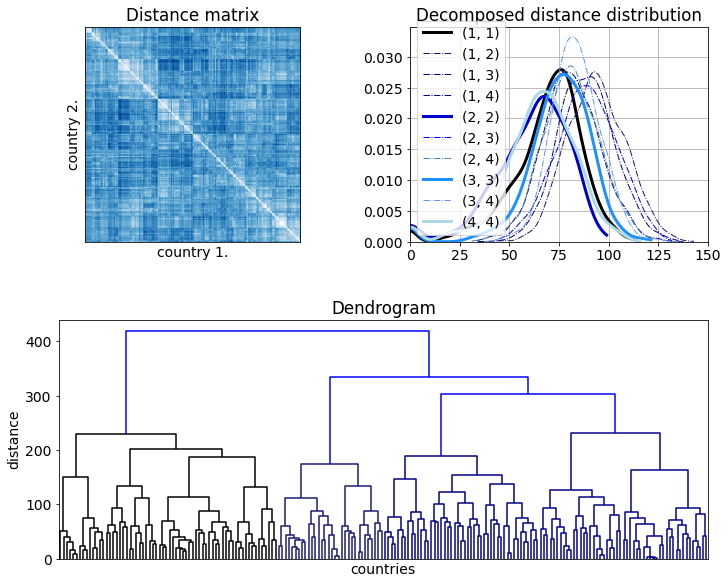

In [59]:
# TO SKIP -- PLOT SETUP
fig = plt.figure(constrained_layout=True)
fig.set_size_inches(10, 8)

gs = fig.add_gridspec(20, 20)
ax1 = fig.add_subplot(gs[0:9, 0:9])
ax2 = fig.add_subplot(gs[0:9, 10:])
ax3 = fig.add_subplot(gs[10:, 0:])

dendro = dendrogram(links_lab, 0, ax = ax3)
flag_order = dendro["leaves"]

# 
ax2.set_title("Decomposed distance distribution")
ax2.set_ylabel(""); ax2.set_ylabel("")
plot_decomposed_horse(
    distances_lab,
    clusters_lab,
    dendro_colours,
    ax2
)

ax3.set_xticks([]); ax3.set_ylabel("distance"); 
ax3.set_title("Dendrogram"); ax3.set_xlabel("countries")
ax3.set_yscale(
    'function',
    functions=(lambda x: x**1, lambda x: x**(1/1))
)

ax1.set_title("Distance matrix")
ax1.imshow(mat_lab[flag_order][:, flag_order], cmap="Blues")
ax1.set_xticks([]); ax1.set_yticks([])
ax1.set_xlabel("country 1."); ax1.set_ylabel("country 2.")

In [50]:
images_small = np.array([lab2rgb(x[::10, ::10]) for x in canvases])

If the flags are associated with the nodes in the dendrogram a few interesting observations can be made. The positions of the the flags will be given in time coordinates. For example that of Germany is at 09:00.
* Nations of similar cultural heritage tend to appear together
    * Arabic countries at 01:30 and 11:00
    * Communist or former communist states at 05:30
    * North Latin America at 04:00
    * Meso American and Carribean countries at 10:00
    * West African countries at 03:30

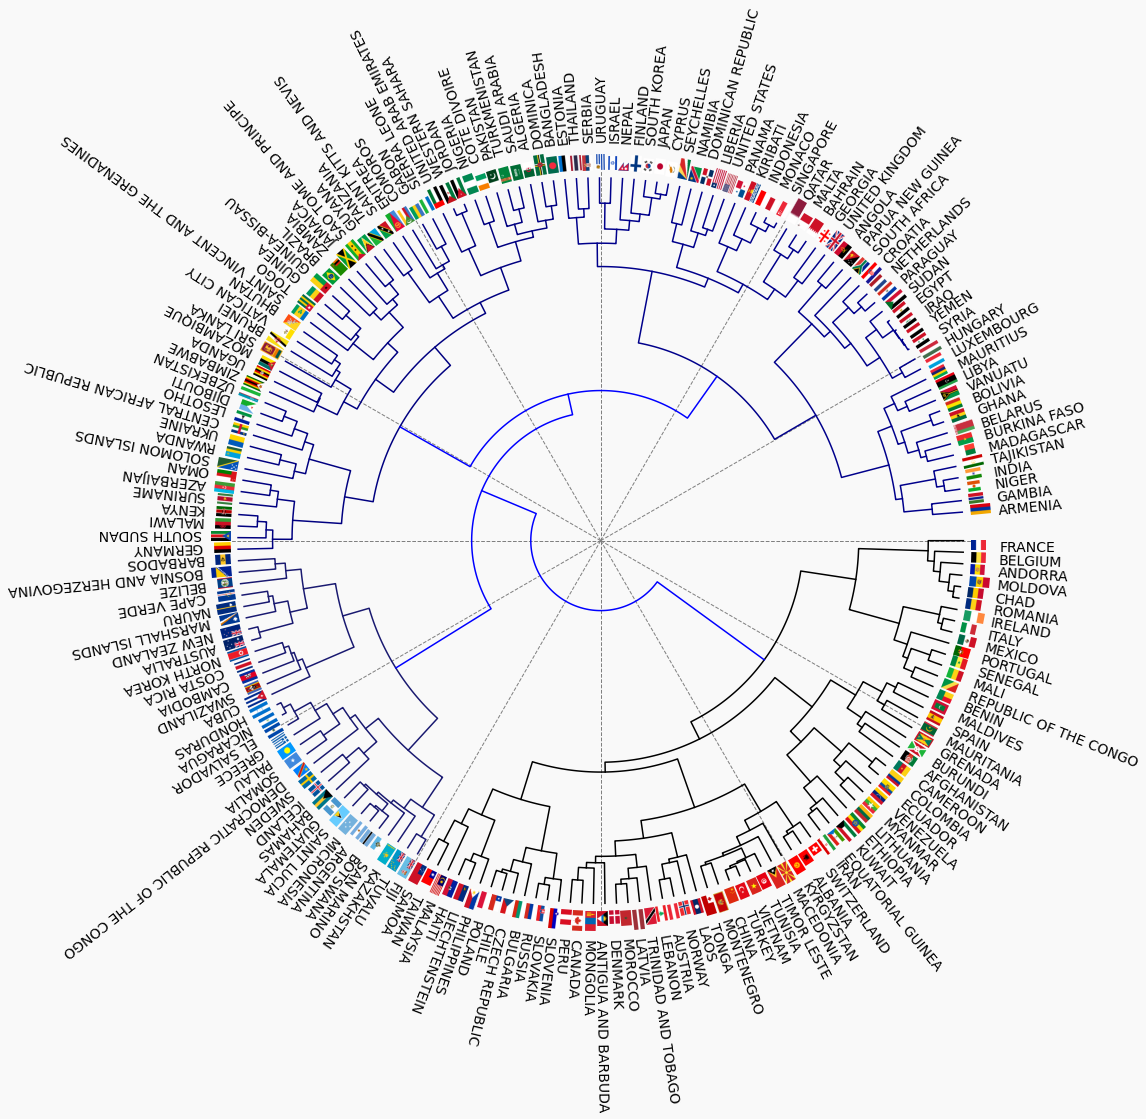

In [60]:
# TO SKIP -- PLOT SETUP
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15, 15)
plot_polar_dendrogram(dendro, ax)
plot_images_on_perimeter(images_small, flag_order, 530, ax)
add_text_on_perimeter(df_flag.index[flag_order], 570, ax)
add_radial_lines(ax, 530)

#### Similarity by component colours

The direct distance over the canvas has one major drawback: it is agnostic of the permutation of colours. For instance, x and y are made up from the same colours but in reversed order. As a consequence, their direct distance will be large, but perceptually they are similar. 

Two flags are similar too, if they are composed of akin colours in close ratios. If we were compare their colour histograms they would be placed close to each other. However, all spatial information is then lost. 

The earth mover's difference is just the appropriate measure to carry out this comparison. Given two flags $F_{i}, F_{j}$, their colours are $\mathcal{C}_{i}, \mathcal{C}_{j}$, and the histograms $\mathbf{w}_{i}, \mathbf{w}_{j}$. The base distance between two colours is the ordinary $L_{2}$ one, which form a distance matrix, $D^{w}_{i}$ for each pairs of flags:

$$
d^{w}_{ij, kl} = ||c_{i,k}, c_{j,l}||_{2} \, .
$$

The earth mover's distance is the minimum amount of work required to transform one histogram to the other:

$$
d^{e}_{i,j} = 
    \frac{\sum\limits_{k=1}^{n_{i}} \sum\limits_{l=1}^{n_{j}} f_{ij,kl}d^{w}_{ij, kl}}
    {\sum\limits_{k=1}^{n_{i}} \sum\limits_{l=1}^{n_{j}} f_{ij,kl}}
$$

subjected to a set of constraints that ensure conservation of the flag area.

In [52]:
# TO SKIP -- BORING
# type cast
cls = [np.array(x) for x in df_flag["colours-lab"]]
ws = [np.array(x) for x in df_flag["fractions"]]

distances_w = []
# ugly double loop over non identical pairs of flags
for i, (cls_1, w_1) in enumerate(zip(cls, ws)):
    for cls_2, w_2 in zip(cls[i+1:], ws[i+1:]):
        dist_mat_ = distance_matrix(cls_1, cls_2)
        distance = calc_emd(dist_mat_, w_1, w_2)
        distances_w.append(distance)
        
distances_w = np.array(distances_w)

/home/bhornung/anaconda3/lib/python3.7/site-packages/scipy/optimize/_linprog_util.py:763: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  warn(redundancy_warning, OptimizeWarning)
/home/bhornung/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:396: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
/home/bhornung/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:396: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'sym_pos' to False.
/home/bhornung/anaconda3/lib/python3.7/site-packages/scipy/optimize/_linprog_ip.

/home/bhornung/anaconda3/lib/python3.7/site-packages/scipy/optimize/_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=8.37623e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/bhornung/anaconda3/lib/python3.7/site-packages/scipy/optimize/_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=9.49104e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/bhornung/anaconda3/lib/python3.7/site-packages/scipy/optimize/_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=1.7182e-33): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/bhornung/anaconda3/lib/python3.7/site-packages/scipy/optimize/_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=3.31627e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/bhornung/anaconda3/lib/python3.7/site-packages/scipy/optimize/_linprog_ip.py:110: LinAlgWarning: Ill-co

/home/bhornung/anaconda3/lib/python3.7/site-packages/scipy/optimize/_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=5.2221e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/bhornung/anaconda3/lib/python3.7/site-packages/scipy/optimize/_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=3.25982e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/bhornung/anaconda3/lib/python3.7/site-packages/scipy/optimize/_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=2.98392e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/bhornung/anaconda3/lib/python3.7/site-packages/scipy/optimize/_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=2.51128e-23): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/bhornung/anaconda3/lib/python3.7/site-packages/scipy/optimize/_linprog_ip.py:110: LinAlgWarning: Ill-co

In [53]:
# TO SKIP - WE HAVE SEEN IT BEFORE
# perform Ward agglomerative clustering
links_w = linkage(distances_w, method="ward")

# get cluster labels
clusters_w = fcluster(links_w, 260, criterion="distance")

# for plotting
mat_w = squareform(distances_w)

The EM distances have been calculated and then clustered in the same way the direct distances were. The distance matrix looks much cleaner and better structure. This is mainly due to clusters 1. and 4. being separated from the others as the right panel in the top row shows.

Text(0, 0.5, 'country 2.')

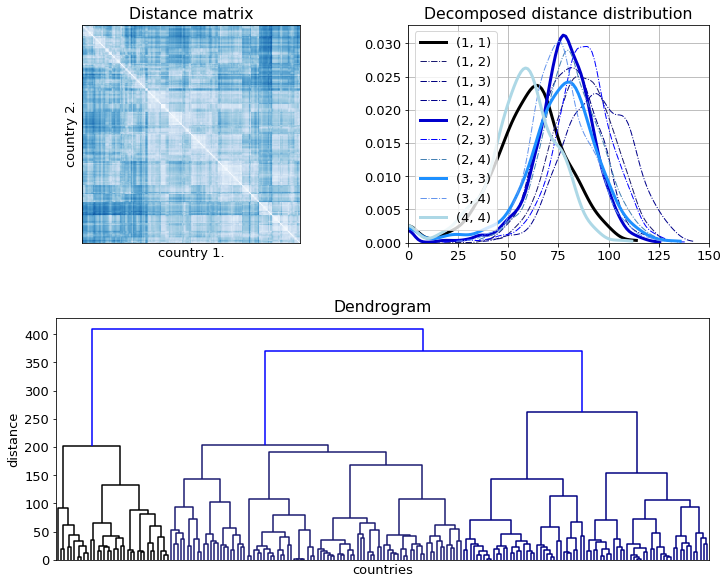

In [54]:
# TO SKIP -- PLOT SETUP
fig = plt.figure(constrained_layout=True)
fig.set_size_inches(10, 8)

gs = fig.add_gridspec(20, 20)
ax1 = fig.add_subplot(gs[0:9, 0:9])
ax2 = fig.add_subplot(gs[0:9, 10:])
ax3 = fig.add_subplot(gs[10:, 0:])

dendro = dendrogram(links_w, 0, ax = ax3)
flag_order = dendro["leaves"]

ax2.set_title("Decomposed distance distribution")
ax2.set_ylabel(""); ax2.set_ylabel("")
plot_decomposed_horse(
    distances_w,
    clusters_w,
    dendro_colours,
    ax2
)

ax3.set_xticks([]); ax3.set_ylabel("distance"); 
ax3.set_title("Dendrogram"); ax3.set_xlabel("countries")
ax3.set_yscale(
    'function',
    functions=(lambda x: x**1, lambda x: x**(1/1))
)

ax1.set_title("Distance matrix")
ax1.imshow(mat_w[flag_order][:, flag_order], cmap="Blues")
ax1.set_xticks([]); ax1.set_yticks([])
ax1.set_xlabel("country 1."); ax1.set_ylabel("country 2.")

The dendrogram look remarkably different. A colour wheel has been generated along which the colours blend in to each other at least within the major clusters. The spatial arrangement of the components is ignored altogether, which becomes apparent by looking at the Indian--Irish pair just below 09:00. 

The following group changes can be observed:
* The Sub-Saharan North African countries are now in one cluster at 08:00
* The two muslim groups are merged in to one at 07:00

In [55]:
# TO SKIP -- PLOT SETUP
plt.rcParams.update({"font.size": 14})
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(20, 20)
plot_polar_dendrogram(dendro, ax)
plot_images_on_perimeter(images_small, flag_order, 530, ax)
add_text_on_perimeter(df_flag.index[flag_order], 570, ax)
add_radial_lines(ax, 530)